First, import the dataset

In [1]:
#Import data handling
import pandas as pd

cancerData = pd.read_csv("../Dataset/lncRNA_5_Cancers.csv")

In [2]:
print(cancerData.shape)

(2529, 12311)


Our dataset consists of 2529 samples (rows) and 12311 features (columns), however 2528 are actual samples and only 12309 are gene features.

The first row is for column label, and two of the columns are Ensembl_ID (first col) and Class (last col).

In [3]:
cancerData['Class'].unique()

array(['KIRC', 'LUAD', 'LUSC', 'PRAD', 'THCA'], dtype=object)

We check to see how many unique cancer types there are:
- KIRC
- LUAD
- LUSC
- PRAD
- THCA

Now we will look at how many samples are from each class.

In [4]:
classCount = cancerData['Class'].value_counts()
print(classCount)

Class
KIRC    527
LUAD    510
THCA    501
LUSC    498
PRAD    493
Name: count, dtype: int64


To create a simple bar chart, I will use matplotlib

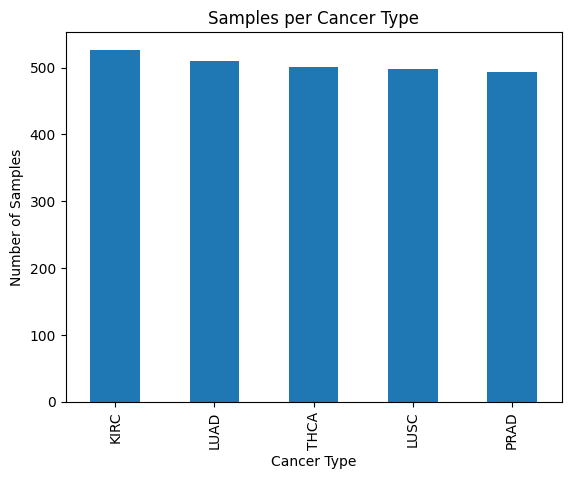

In [5]:
import matplotlib.pyplot as matplot

classCount.plot(kind='bar')
matplot.title("Samples per Cancer Type")
matplot.xlabel("Cancer Type")
matplot.ylabel("Number of Samples")
matplot.show()


In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Prepare data, remove non-feature columns
x = cancerData.drop(columns=['Class', 'Ensembl_ID']).values
yString = cancerData['Class'].values
le = LabelEncoder()
y = le.fit_transform(yString)
classNames = le.classes_


In [7]:
# from sklearn.svm import SVC
from thundersvm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Set up the svm and the kfolds
thunSVM = SVC(kernel="rbf", probability=True, random_state=42, n_jobs=-1)
crossValidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

# Report information for the first fold
targetFold = 0
for foldIdX, (trainIdX, testIdX) in enumerate(crossValidation.split(x, y)):
    if foldIdX != targetFold:
        continue
        
    xTrain, xTest = xScaled[trainIdX], xScaled[testIdX]
    yTrain, yTest = y[trainIdX], y[testIdX]

    scaler = StandardScaler()
    xTrainScaled = scaler.fit_transform(xTrain)
    xTestScaled = scaler.fit_transform(xTest)

    
    thunSVM.fit(xTrainScaled, yTrain)
    yPrediction = thunSVM.predict(xTestScaled)

    cm = confusion_matrix(yTest, yPrediction, labels=np.arrange(len(classNames)))
    cm_df = pd.DataFrame(cm,
                         index=[f"true_{c}" for c in classNames],
                         columns=[f"pred_{c}" for c in classNames])
    print(f"Confusion Matrix for Fold {foldIdX}:")
    display(cm_df)

In [9]:
yPrediction = cross_val_predict(svm, xScaled, y, cv=crossValidation, method="predict", n_jobs=-1)
yProbability = cross_val_predict(svm, xScaled, y, cv=crossValidation, method="predict_proba", n_jobs=-1)

In [10]:
print(confusion_matrix(y, yPrediction))
print(classification_report(y, yPrediction, digits=4))


[[516   5   6   0   0]
 [  0 495  15   0   0]
 [  0  48 450   0   0]
 [  0   3   1 489   0]
 [  0   5   0   0 496]]
              precision    recall  f1-score   support

        KIRC     1.0000    0.9791    0.9895       527
        LUAD     0.8903    0.9706    0.9287       510
        LUSC     0.9534    0.9036    0.9278       498
        PRAD     1.0000    0.9919    0.9959       493
        THCA     1.0000    0.9900    0.9950       501

    accuracy                         0.9672      2529
   macro avg     0.9687    0.9670    0.9674      2529
weighted avg     0.9687    0.9672    0.9674      2529



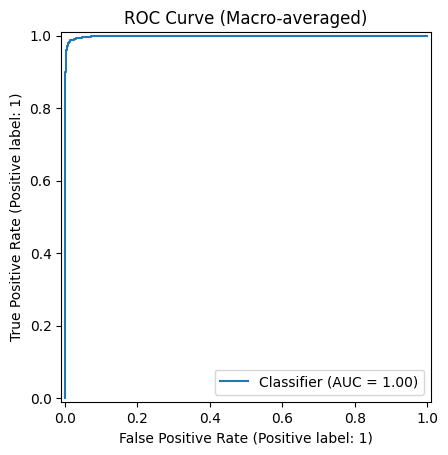

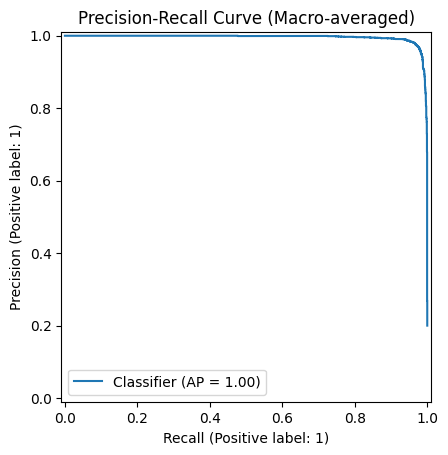

In [11]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize labels for multiclass ROC/PR
yBin = label_binarize(y, classes=sorted(y.unique()))

# Macro-average ROC
RocCurveDisplay.from_predictions(yBin.ravel(), yProbability.ravel())
matplot.title("ROC Curve (Macro-averaged)")
matplot.show()

# Macro-average PR
PrecisionRecallDisplay.from_predictions(yBin.ravel(), yProbability.ravel())
matplot.title("Precision-Recall Curve (Macro-averaged)")
matplot.show()